<a href="https://colab.research.google.com/github/DoubleCyclone/Neural-Network-From-Scratch/blob/main/notebooks/Neural_Network_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Introduction & Setup
As a Machine Learning student (self-proclaimed), I am learning how to build and use various models. In this notebook specifically, I will create my own Neural Network from Scratch with Numpy.

I will be using the [**MNIST**](https://www.kaggle.com/datasets/hojjatk/mnist-dataset) dataset to train the model and run predictions.

Let's import the packages first.

In [215]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

At first I have to load the MNIST dataset. I will do this with pytorch as it does not really have anything to do with model building right now so it is not cheating!

In [216]:
# Load the MNIST dataset with the specified transformation
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Create a DataLoader to load the dataset in batches
loader_train = torch.utils.data.DataLoader(mnist_train, batch_size=1, shuffle=False)
loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=1, shuffle=False)

After loading our train and test Datasets and the DataLoaders, I want to check how much data they contain.

In [217]:
print(f"Train data shape : {loader_train.dataset.data.shape}")
print(f"Train labels shape : {loader_train.dataset.targets.shape}")
print(f"Test data shape : {loader_test.dataset.data.shape}")
print(f"Test labels shape : {loader_test.dataset.targets.shape}")

Train data shape : torch.Size([60000, 28, 28])
Train labels shape : torch.Size([60000])
Test data shape : torch.Size([10000, 28, 28])
Test labels shape : torch.Size([10000])


There are 60000 images in the training set and 10000 in the test set. The images are of 28x28 size. Now let's plot a few of the data with their labels as visualization is of utmost importance especially when learning.

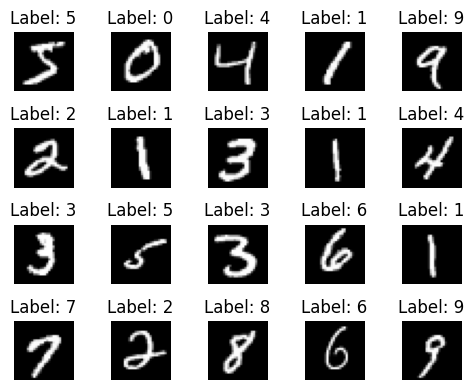

In [218]:
# Create a figure to display the images
fig, axs = plt.subplots(4, 5 , figsize=(5, 4))

# Flatten to iterate easily
axs = axs.flatten()

# Print the first few images in a row
for i, (image, label) in enumerate(loader_train):
    # Print the first 20 samples
    if i < 20:
        axs[i].imshow(image[0].squeeze(), cmap='gray') # Show the image
        axs[i].set_title(f"Label: {label.item()}") # Set the label as the title
        axs[i].axis('off') # Turn off axis to make the image cleaner
    else:
        break  # Exit the loop after printing 20 samples

# Fix overlap and show the plot
fig.tight_layout()
fig.show()

What about checking how one example looks in numerical form?

In [219]:
loader_train.dataset.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

Seems like the background (black) is encoded as 0 and greater than 0 are the foreground (white/whiteish) where it gets lighter the further away it gets from 0.

For our handmade Neural Network, I will set up just one hidden layer. Output node count has to be equal to the class count which is 10 (numbers from 0 to 9). Input node count has to be equal to the image size which is 28 x 28 = 784 pixels.

# 2 - Building Mathematical Components
As activation functions, I will be using **ReLU** (Rectified Linear Unit) for hidden layers as it helps with vanishing gradient problem and **Softmax** for the output layer so that their probabilities' sum will be equal to 1 (100%). Let's start by implementing **ReLU** and plotting it.

In [220]:
# Relu function
def relu(x : float) :
  return np.maximum(0, x)

Let's also create a simple plotting function to easily visualize our implemented functions.

In [221]:
def plot_func(func, x) :
  # plot x versus y (func(x))
  plt.plot(x, [func(val) for val in x])
  plt.xlabel("x")
  plt.ylabel("Function")
  plt.show()

Now let's visualize to check if the function is correct.

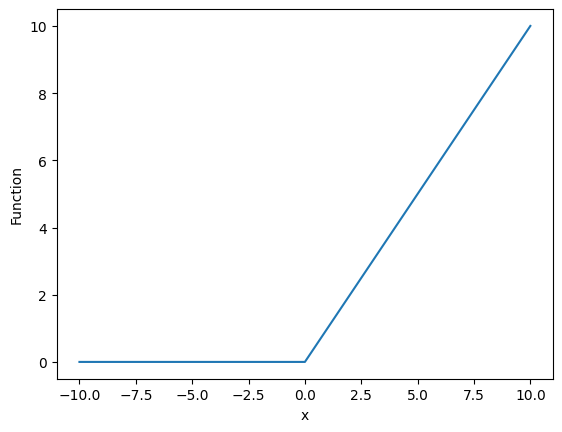

In [222]:
# decide on some x values for plotting
x = [i for i in range(-10, 11, 1)]

plot_func(relu, x)

I will have to implement the derivatives of these functions as they will be needed later on.

In [223]:
def d_relu(x) :
  return x > 0

Visualize this one as well.

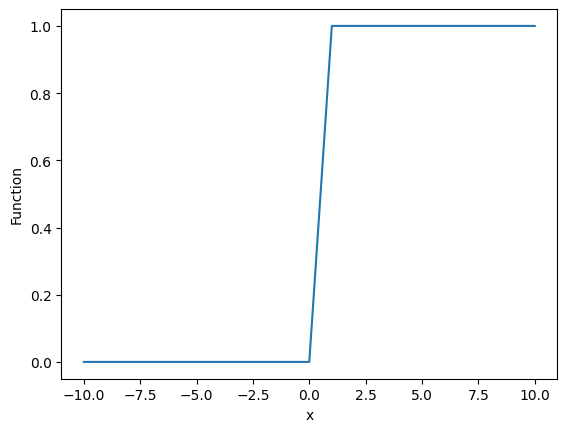

In [224]:
plot_func(d_relu, x)

Now I will implement the **Softmax** function.

In [225]:
def softmax(logits) :
  exp_logits = np.exp(logits - np.max(logits, axis=-1, keepdims=True))
  return exp_logits / np.sum(exp_logits, axis=-1, keepdims=True)

In [226]:
# Create a simple vector for testing
vector = [1, 3, 2]

# Test the function
print(softmax(vector))

[0.09003057 0.66524096 0.24472847]


Seems like the softmax function is working as intended as well. For a model to evaluate how much error it has, we need a **Loss Function**. As this is a multiclass classification task, I can use something called a **Categorical Cross-entropy loss**. It measures the difference between the predicted probability distribution and the true one-hot encoded labels, penalizing the model when confidence is low on the correct class. Now let's implement it.

In [227]:
def categorical_cross_entropy(pred_labels, true_labels) :
  # Return if predictions and labels aren't the same size
  if len(pred_labels) != len(true_labels) :
    print(f"Prediction label count = {len(pred_labels)}, True label count = {len(true_labels)}")
    return

  # Add a small epsilon to pred_labels to prevent log(0)
  epsilon = 1e-9
  pred_labels = np.clip(pred_labels, epsilon, 1 - epsilon)
  return -np.sum(true_labels * np.log(pred_labels))

Now let's test the function. Note that our loss function requires one-hot encoded labels.

In [228]:
true_label = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0] # Example one-hot encoding for class 4, length 10 for MNIST
preds = softmax(np.random.rand(10)) # Generate 10 random logits for 10 classes

# Has to be 1 (floating point precision problem may make this 0.99999999 or 1.00000002 or similar)
print(np.sum(preds))

print(categorical_cross_entropy(preds, true_label))

1.0
2.4341491377619993


In [229]:
def d_categorical_cross_entropy(pred_labels, true_labels) :
  return pred_labels - true_labels

In [230]:
print(d_categorical_cross_entropy(np.asarray([0.15, 0.4, 0.46]), np.asarray([1, 0, 0])))

[-0.85  0.4   0.46]


Now that our functions are ready, I can start building some matrices so that they form a neural network. For weights, there are a few initialization strategies like **Xavier Initialization** and **He Initialization**. First one is more suitable for layers that use **TANH** and **Sigmoid** activation function whereas the second one is better when paired with **ReLU** activation function.

To decide on the size of our only hidden layer, I will follow a few rule-of-thumb methods:
1. The number of hidden neurons should be between the size of the input layer and the size of the output layer.
2. The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
3. The number of hidden neurons should be less than twice the size of the input layer.

So if I were to follow the second rule, the hidden layer should have 533 (532,6 rounded up) nodes. Now let's build the layers.

In [231]:
# Calculate total nodes on each layer
input_node_count = loader_train.dataset.data.shape[1] * loader_train.dataset.data.shape[2]
output_node_count = len(np.unique(loader_train.dataset.targets.numpy()))
hidden_node_count = np.ceil((input_node_count * 2 / 3) + output_node_count).astype(int)

# Initialize node weights
input_hidden_weights = np.random.randn(input_node_count, hidden_node_count) * np.sqrt(2 / input_node_count)
hidden_output_weights = np.random.randn(hidden_node_count, output_node_count) * np.sqrt(2 / hidden_node_count)

# Initialize node biases
hidden_biases = np.zeros(shape=(hidden_node_count))
output_biases = np.zeros(shape=(output_node_count))

print(f"Input-Hidden Layer weights amount : {input_hidden_weights.shape}")
print(f"Hidden-Output Layer weights amount : {hidden_output_weights.shape}")
print(f"Hidden biases Layer amount : {hidden_biases.shape}")
print(f"Output biases Layer amount : {output_biases.shape}")

Input-Hidden Layer weights amount : (784, 533)
Hidden-Output Layer weights amount : (533, 10)
Hidden biases Layer amount : (533,)
Output biases Layer amount : (10,)


# 3 - Forward Propagation
Now that our layers are ready, it is time to add them together so that they can perform a single forward pass. But before that, I will scale the data so that the range of brightness is reduced from 0-255 to 0-1 as it is infinitely more manageable to work with smaller numbers. I can do this by adding a **Normalization Layer** before any weights or biases are applied. After that, I will also One-Hot encode the labels to be able to compare them with the output probabilities easily.

In [232]:
def apply_normalization(data) :
  # Flatten the input image so it is like one vector
  data_flat = torch.Tensor.numpy(data.flatten())
  # Scale it from 0-255 to 0-1 for a better range
  return data_flat / 255

In [233]:
def apply_one_hot_encoding(labels):
  # Shape the new labels with rows equal to old labels but cols equal to output node count
  oh_encoded = np.empty(shape=(len(labels), output_node_count))
  for i, row in enumerate(oh_encoded) :
    # set all cells to 0 and only the label cell to 1
    oh_encoded[i] = 0
    oh_encoded[i, labels[i]] = 1
  return oh_encoded

After this normalization, I will multiply all the neurons in the input layer by the weights that were initialized earlier.

In [234]:
def apply_weights(data, weights):
    return np.dot(data, weights)

Then the biases will be added to the outputs from the weight multiplication.

In [235]:
def apply_biases(data, biases):
    return data + biases

After that, the activation function (ReLU) will be applied to the outputs so that the values are 0 or greater than 0. Lastly, Softmax will be applied so that the logits will be turned into meaningful predictions that sum up to 1. I already implemented ReLU and Softmax earlier so let's just add them all together for a single forward pass.

In [236]:
def single_forward(data, weights_1, biases_1, weights_2, biases_2) :
  # run normalization -> weights -> biases -> activation -> weights -> biases -> softmax
  input = apply_normalization(data)
  z1 = apply_biases(apply_weights(input, weights_1), biases_1)
  a1 = relu(z1)
  z2 = apply_biases(apply_weights(a1, weights_2), biases_2)
  a2 = softmax(z2)

  # Return both final output AND intermediate values
  cache = {
      'input': input,
      'z1': z1,
      'a1': a1,
      'z2': z2,
      'a2' : a2
  }
  return a2, cache

Let's test it and see if the outputs make sense.

In [237]:
# Perform a single forward pass
preds, cache = single_forward(loader_train.dataset.data[0], input_hidden_weights, hidden_biases, hidden_output_weights, output_biases)

# One-Hot Encode the first label for testing
true_label_one_hot = apply_one_hot_encoding([loader_train.dataset.targets[0].item()])[0]

# Calculate the loss
loss = categorical_cross_entropy(preds, true_label_one_hot)

print(f"Predicted class : {np.argmax(preds)}")
print(f"Prediction values : {preds}")
print(f"Sum of predictions : {preds.sum()}")
print(f"Loss : {loss}")

Predicted class : 9
Prediction values : [0.07647885 0.08710984 0.08265687 0.05010338 0.11101674 0.09103144
 0.07407676 0.12963223 0.14129642 0.15659747]
Sum of predictions : 0.9999999999999999
Loss : 2.3965503010328084


As can be seen from the sum and the values themselves, they sum up to 1 which was exactly what I wanted. Note that currently as the model is not being trained at all (only random initialization), its predictions are random.
# 4 - Backward propagation
To be able to train the model, I need to implement something called "**Backward Propagation**" which is the process of calculating how much each weight and bias should change with respect to the current error of the prediction. For this, I need to implement the derivatives of the weights and biases on the layers with respect to the ones in the previous layers. Naturally, we start from the end which is why it is called **Backward propagation**. Last biases' contributions to the loss were directly proportionate as they are added at the end. Fortunately the **Softmax** function and the **Cross-Entropy Loss** functions' derivatives cancel out most calculations, leaving only "predictions - true labels" for us to calculate.

In the next step, I need to calculate how much the weights between the hidden-output layers contribute to the losses so that we can increase/decrease their values accordingly. For this, we need the gradient from the latest step and the input to the layer. With these, we calculate the outer product of them so that we end up with same amount of gradients as the weight count.

Then we propagate error back to the hidden layer on which the ReLU derivative will be applied to check if the neurons were active or inactive.

From there, the same gradient after the ReLU derivative will be applied to the biases on the hidden layer as they are also directly proportionate to the value after the activation.

Lastly, for the weights between the Input-Hidden layer, that same relu derivative applied gradient will be used to calculate the gradients along with the cached input values.

In [238]:
def single_backward(cache, true_labels, weights_2):
    # Gradient at output (this is the magic simplification!)
    dL_dz2 = d_categorical_cross_entropy(cache['a2'], true_labels)  # (10,)

    # Gradients for second layer
    dL_dbiases2 = dL_dz2  # (10,)
    dL_dweights2 = np.outer(cache['a1'], dL_dz2)  # (533, 10)

    # Propagate error back to hidden layer
    dL_da1 = np.dot(dL_dz2, weights_2.T)  # (533,)

    # Apply ReLU derivative
    dL_dz1 = dL_da1 * d_relu(cache['z1'])  # (533,)

    # Gradients for first layer
    dL_dbiases1 = dL_dz1  # (533,)
    dL_dweights1 = np.outer(cache['input'], dL_dz1)  # (784, 533)

    return {
        'dL_dweights1': dL_dweights1,
        'dL_dbiases1': dL_dbiases1,
        'dL_dweights2': dL_dweights2,
        'dL_dbiases2': dL_dbiases2
    }

In [239]:
gradients = single_backward(cache, torch.Tensor.numpy(loader_train.dataset.targets[0]), hidden_output_weights)

# 5 - Training Loop
After calculating these gradients, I will update the weights/biases in the network so that the next forward pass will yield better results. As I already have implemented the forward pass and backward propagation, the next thing we need will be deciding on some **Hyperparameters** like **Learning Rate** so that we can amplify how much the gradients affect our model parameters with each pass.

Also, it is often better to run the gradient descent on mini-batches instead of after every sample. This is done by splitting the data into smaller chunks and running gradient descent after each chunk has been processed instead which is computationally cheaper.

I also will split the training set into training and validation sets.

In [240]:
# Divide into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(loader_train.dataset.data, loader_train.dataset.targets, test_size=0.16666, random_state=42)
X_test = loader_test.dataset.data
y_train = apply_one_hot_encoding(y_train)
y_val = apply_one_hot_encoding(y_val)
y_test = apply_one_hot_encoding(loader_test.dataset.targets)

print(f"Shape of training set : {X_train.shape}")
print(f"Shape of validation set : {X_val.shape}")
print(f"Shape of test set : {X_test.shape}")
print(f"Shape of training labels : {y_train.shape}")
print(f"Shape of validation labels : {y_val.shape}")
print(f"Shape of test labels : {y_test.shape}")

Shape of training set : torch.Size([50000, 28, 28])
Shape of validation set : torch.Size([10000, 28, 28])
Shape of test set : torch.Size([10000, 28, 28])
Shape of training labels : (50000, 10)
Shape of validation labels : (10000, 10)
Shape of test labels : (10000, 10)


Now it is time to build the Model class.

In [241]:
class Model() :
  def __init__(self, input_node_count, hidden_node_count, output_node_count) :
    # Initialize node weights
    self.w1 = np.random.randn(input_node_count, hidden_node_count) * np.sqrt(2 / input_node_count)
    self.w2 = np.random.randn(hidden_node_count, output_node_count) * np.sqrt(2 / hidden_node_count)
    # Initialize node biases
    self.b1 = np.zeros(shape=(hidden_node_count))
    self.b2 = np.zeros(shape=(output_node_count))

  # Call forward pass
  def __forward(self, data) :
    return single_forward(data, self.w1, self.b1, self.w2, self.b2)

  # Call backward propagation
  def __backward(self, cache, true_labels) :
    return single_backward(cache, true_labels, self.w2)

  # Update weights with respect to the gradients and learning rate
  def __update_weights(self, gradients, learning_rate) :
    self.w1 -= gradients['dL_dweights1'] * learning_rate
    self.b1 -= gradients['dL_dbiases1'] * learning_rate
    self.w2 -= gradients['dL_dweights2'] * learning_rate
    self.b2 -= gradients['dL_dbiases2'] * learning_rate

  def train(self, epochs, batch_size, learning_rate, X_train, y_train, X_val, y_val) :
    # For every epoch
    for epoch in range(epochs) :
      # Shuffle the data
      X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=42)

      # Calculate how many complete batches we can make
      num_batches = len(X_train_shuffled) // batch_size

      # Track loss for this epoch
      epoch_loss = 0

      # For every batch
      for batch_idx in range(num_batches) :
        # print(f"Epoch : {epoch + 1}, Batch : {batch_idx + 1}")

        # Calculate where the batch starts and ends
        batch_start = batch_idx * batch_size
        batch_end = batch_start + batch_size

        # Sample a batch
        X_batch = X_train_shuffled[batch_start:batch_end]
        y_batch = y_train_shuffled[batch_start:batch_end]

        # Initialize gradient accumulators (all zeros)
        accumulated_grads = {
            'dL_dweights1': np.zeros_like(self.w1),
            'dL_dbiases1': np.zeros_like(self.b1),
            'dL_dweights2': np.zeros_like(self.w2),
            'dL_dbiases2': np.zeros_like(self.b2)
        }

        # Initialize batch loss to 0
        batch_loss = 0

        # For every sample in the batch
        for i in range(batch_size) :
          # Run predictions
          predictions, cache = self.__forward(X_batch[i])

          # Calculate the loss for one sample and add it to the batch loss
          sample_loss = categorical_cross_entropy(predictions, y_batch[i])
          batch_loss += sample_loss

          # Backward propagation
          gradients = self.__backward(cache, y_batch[i])

          # Accumulate gradients
          accumulated_grads['dL_dweights1'] += gradients['dL_dweights1']
          accumulated_grads['dL_dbiases1'] += gradients['dL_dbiases1']
          accumulated_grads['dL_dweights2'] += gradients['dL_dweights2']
          accumulated_grads['dL_dbiases2'] += gradients['dL_dbiases2']

        # Average the gradients
        accumulated_grads['dL_dweights1'] /= batch_size
        accumulated_grads['dL_dbiases1'] /= batch_size
        accumulated_grads['dL_dweights2'] /= batch_size
        accumulated_grads['dL_dbiases2'] /= batch_size

        # Update the parameters with the averaged gradients
        self.__update_weights(accumulated_grads, learning_rate)

        # Track average loss for this batch
        epoch_loss += batch_loss / batch_size

      # Calculate average loss for the epoch
      avg_epoch_loss = epoch_loss / num_batches

      # Print progress
      print(f"Epoch {epoch + 1}/{epochs}, Average Loss: {avg_epoch_loss:.4f}")


Time to test the model class in training.

In [242]:
model_np = Model(input_node_count, hidden_node_count, output_node_count)

model_np.train(40, 64, 0.01, X_train, y_train, X_val, y_val)

Epoch 1/40, Average Loss: 0.8464
Epoch 2/40, Average Loss: 0.4156
Epoch 3/40, Average Loss: 0.3485
Epoch 4/40, Average Loss: 0.3142
Epoch 5/40, Average Loss: 0.2909
Epoch 6/40, Average Loss: 0.2730
Epoch 7/40, Average Loss: 0.2584
Epoch 8/40, Average Loss: 0.2458
Epoch 9/40, Average Loss: 0.2347
Epoch 10/40, Average Loss: 0.2248
Epoch 11/40, Average Loss: 0.2158
Epoch 12/40, Average Loss: 0.2075
Epoch 13/40, Average Loss: 0.1999
Epoch 14/40, Average Loss: 0.1928
Epoch 15/40, Average Loss: 0.1863
Epoch 16/40, Average Loss: 0.1801
Epoch 17/40, Average Loss: 0.1744
Epoch 18/40, Average Loss: 0.1690
Epoch 19/40, Average Loss: 0.1639
Epoch 20/40, Average Loss: 0.1592
Epoch 21/40, Average Loss: 0.1547
Epoch 22/40, Average Loss: 0.1504
Epoch 23/40, Average Loss: 0.1464
Epoch 24/40, Average Loss: 0.1425
Epoch 25/40, Average Loss: 0.1389
Epoch 26/40, Average Loss: 0.1354
Epoch 27/40, Average Loss: 0.1321
Epoch 28/40, Average Loss: 0.1290
Epoch 29/40, Average Loss: 0.1260
Epoch 30/40, Average Lo